In [3]:
#step1

In [4]:
# ===== Cell 1: 安裝與導入套件 =====
# 如果缺少套件，請先執行：
!pip install pandas numpy matplotlib seaborn plotly scipy scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import os
import glob
import warnings
from pathlib import Path
from datetime import datetime
from scipy import stats
import json

warnings.filterwarnings('ignore')

# 設定中文字體（Mac/Linux）
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'DejaVu Sans']
# Windows 用戶改用：
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

# 設定視覺化風格
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("✅ 套件載入完成")
print(f"📍 當前工作目錄: {os.getcwd()}")


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ 套件載入完成
📍 當前工作目錄: c:\Users\user\Desktop\step 1~5 - 終 - 看這個\step_3,4,5\orkspace


In [5]:
# ===== Cell 2: 建立專案資料夾結構 =====

def create_project_structure():
    """建立專案所需的資料夾結構"""
    folders = [
        'data/raw',
        'data/processed',
        'reports/figures/raw_timeseries',
        'reports/figures/delta_timeseries',
        'reports/figures/arduino_features',  # 👈 新增：Arduino 特徵視覺化
        'reports/figures/distributions',
        'reports/figures/stability',
        'reports/figures/correlation',
        'reports/figures/sensor_health',     # 👈 新增：感測器健康度
        'reports/summary'
    ]
    
    for folder in folders:
        Path(folder).mkdir(parents=True, exist_ok=True)
    
    print("✅ 資料夾結構建立完成：")
    for folder in folders:
        print(f"   📁 {folder}")

create_project_structure()

✅ 資料夾結構建立完成：
   📁 data/raw
   📁 data/processed
   📁 reports/figures/raw_timeseries
   📁 reports/figures/delta_timeseries
   📁 reports/figures/arduino_features
   📁 reports/figures/distributions
   📁 reports/figures/stability
   📁 reports/figures/correlation
   📁 reports/figures/sensor_health
   📁 reports/summary


In [6]:
!pip install openpyxl


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# ===== Cell 3: 資料載入器 (合併版) - 同時支援標準 & 共用 & 配對 Air =====

import pandas as pd
import glob
import os

class PineappleDataLoader:
    def __init__(self, data_dir='data/raw'):
        self.data_dir = data_dir
        self.air_data = {}
        self.pineapple_data = {}
        self.shared_air_data = {}
        self.PAIR_MAP = {
            '01': '02', '02': '01',
            '03': '04', '04': '03',
            '05': '06', '06': '05',
            '07': '08', '08': '07',
        }

    def load_all_data(self):
        xlsx_files = glob.glob(os.path.join(self.data_dir, '*.xlsx'))
        if not xlsx_files:
            print(f"❌ 在 {self.data_dir} 找不到 Excel 檔案")
            return
        print(f"🔍 找到 {len(xlsx_files)} 個 Excel 檔案")
        for file_path in sorted(xlsx_files):
            filename = os.path.basename(file_path)
            self._parse_and_load(file_path, filename)
        n_dedicated = len([k for k in self.air_data if not k.startswith('shared')])
        print(f"\n✅ 載入完成:")
        print(f"  🌬️ 專屬 Air baseline: {n_dedicated}")
        print(f"  🌬️ 共用 Air baseline: {len(self.shared_air_data)}")
        print(f"  🍍 Pineapple: {len(self.pineapple_data)} 顆")
        return self.air_data, self.pineapple_data, self.shared_air_data

    def _parse_and_load(self, file_path, filename):
        try:
            parts = filename.replace('.xlsx', '').split('_')
            is_air = 'air' in parts

            if is_air:
                if len(parts) == 3:
                    # 共用 air：pineapple_20260203_air.xlsx
                    date = parts[1]
                    pineapple_id = None
                elif len(parts) == 4:
                    # 專屬 air：pineapple_01_20260203_air.xlsx
                    pineapple_id = parts[1]
                    date = parts[2]
                else:
                    print(f"⚠️ 無法解析 air 檔案格式: {filename}")
                    return
            else:
                if len(parts) >= 3:
                    pineapple_id = parts[1]
                    date = parts[2]
                else:
                    print(f"⚠️ 跳過不符合命名規則的檔案: {filename}")
                    return

            df = self._read_excel_with_validation(file_path, filename)
            if df is None:
                return

            if is_air:
                if pineapple_id is None:
                    self.shared_air_data[date] = df
                    self.air_data[f"shared_{date}"] = df
                    print(f"  ✓ 共用 Air: {filename} ({len(df)} rows) → 日期={date}")
                else:
                    air_key = f"{pineapple_id}_{date}"
                    self.air_data[air_key] = df
                    print(f"  ✓ 專屬 Air: {filename} ({len(df)} rows) → key={air_key}")
            else:
                self.pineapple_data.setdefault(pineapple_id, {})[date] = df
                print(f"  ✓ Pineapple: {filename} ({len(df)} rows)")

        except Exception as e:
            print(f"❌ 載入失敗 {filename}: {e}")

    def _read_excel_with_validation(self, file_path, filename):
        required_cols = [
            'timestamp_ms', 'MQ2_raw', 'MQ3_raw', 'MQ9_raw',
            'MQ135_raw', 'TGS2602_raw', 'Temp_C', 'Humidity_pct', 'Pressure_hPa'
        ]
        try:
            df = pd.read_excel(file_path, engine='openpyxl')
            first_col = str(df.columns[0])
            if first_col.startswith('#') or 'MODE' in first_col or 'Unnamed' in first_col:
                df = pd.read_excel(file_path, engine='openpyxl', skiprows=1)
            missing_cols = [c for c in required_cols if c not in df.columns]
            if missing_cols:
                print(f"⚠️ {filename} 缺少欄位: {missing_cols}")
                return None
            for col in required_cols:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            df = df.dropna(subset=['timestamp_ms']).reset_index(drop=True)
            return df
        except Exception as e:
            print(f"❌ 讀取錯誤 {filename}: {e}")
            return None

    def get_air_baseline(self, pineapple_id, date):
        """優先順序：① 專屬 → ② 共用 → ③ 配對鳳梨 → ④ None"""
        # ① 專屬
        dedicated_key = f"{pineapple_id}_{date}"
        if dedicated_key in self.air_data:
            return self.air_data[dedicated_key], "專屬"
        # ② 共用
        if date in self.shared_air_data:
            return self.shared_air_data[date], "共用"
        # ③ 配對鳳梨
        partner_id = self.PAIR_MAP.get(pineapple_id)
        if partner_id:
            partner_key = f"{partner_id}_{date}"
            if partner_key in self.air_data:
                return self.air_data[partner_key], f"配對({partner_id})"
        return None, "無"


# ── 執行 ──
loader = PineappleDataLoader('data/raw')
air_data, pineapple_data, shared_air_data = loader.load_all_data()

print("\n📊 載入詳情:")
print(f"Pineapple IDs: {list(pineapple_data.keys())}")
for pid, dates in pineapple_data.items():
    print(f"  🍍 {pid}: {list(dates.keys())}")

# 驗證缺 air 的日期
print("\n🔍 驗證缺 air 的日期：")
check_cases = [
    ('06', '20260202'),
    ('07', '20260203'),
    ('08', '20260205'),
    ('05', '20260202'),
]
for pid, date in check_cases:
    air_df, air_type = loader.get_air_baseline(pid, date)
    status = f"({len(air_df)} rows)" if air_df is not None else "❌ 找不到"
    print(f"  🍍 {pid} @ {date}: {air_type} {status}")


🔍 找到 234 個 Excel 檔案
  ✓ Pineapple: pineapple_01_20260201.xlsx (900 rows)
  ✓ 專屬 Air: pineapple_01_20260201_air.xlsx (900 rows) → key=01_20260201
  ✓ Pineapple: pineapple_01_20260202.xlsx (900 rows)
  ✓ 專屬 Air: pineapple_01_20260202_air.xlsx (900 rows) → key=01_20260202
  ✓ Pineapple: pineapple_01_20260203.xlsx (900 rows)
  ✓ 專屬 Air: pineapple_01_20260203_air.xlsx (900 rows) → key=01_20260203
  ✓ Pineapple: pineapple_01_20260204.xlsx (900 rows)
  ✓ 專屬 Air: pineapple_01_20260204_air.xlsx (900 rows) → key=01_20260204
  ✓ Pineapple: pineapple_01_20260205.xlsx (900 rows)
  ✓ 專屬 Air: pineapple_01_20260205_air.xlsx (900 rows) → key=01_20260205
  ✓ Pineapple: pineapple_01_20260206.xlsx (900 rows)
  ✓ 專屬 Air: pineapple_01_20260206_air.xlsx (900 rows) → key=01_20260206
  ✓ Pineapple: pineapple_01_20260207.xlsx (900 rows)
  ✓ 專屬 Air: pineapple_01_20260207_air.xlsx (900 rows) → key=01_20260207
  ✓ Pineapple: pineapple_01_20260208.xlsx (900 rows)
  ✓ 專屬 Air: pineapple_01_20260208_air.xlsx (900 rows

In [8]:
# ===== Cell 4: 資料清洗器 + 感測器健康度檢查 =====

class DataCleaner:
    """資料清洗與驗證"""
    
    def __init__(self):
        # 定義異常值範圍（根據你的 Arduino code）
        self.validation_rules = {
            'MQ2_raw': (10, 1000),
            'MQ3_raw': (10, 1000),
            'MQ9_raw': (10, 1000),
            'MQ135_raw': (10, 1000),
            'TGS2602_raw': (10, 1000),
            'Temp_C': (0, 50),
            'Humidity_pct': (0, 100),
            'Pressure_hPa': (800, 1100)
        }
        self.sensor_cols = ['MQ2_raw', 'MQ3_raw', 'MQ9_raw', 'MQ135_raw', 'TGS2602_raw']
    
    def clean_dataset(self, df, dataset_name="Dataset"):
        """清洗單一數據集"""
        print(f"\n🧹 清洗 {dataset_name}...")
        
        original_rows = len(df)
        
        # 1. 移除完全重複的行
        df = df.drop_duplicates()
        
        # 2. 檢查並處理缺值
        missing_before = df.isnull().sum().sum()
        if missing_before > 0:
            print(f"   ⚠️  發現 {missing_before} 個缺值")
            df = df.dropna().reset_index(drop=True)  # 👈 關鍵：重置 index
        
        # 3. 異常值過濾
        mask = pd.Series([True] * len(df))
        outlier_counts = {}
        
        for col, (min_val, max_val) in self.validation_rules.items():
            if col in df.columns:
                col_mask = (df[col] >= min_val) & (df[col] <= max_val)
                outliers = (~col_mask).sum()
                if outliers > 0:
                    outlier_counts[col] = outliers
                mask &= col_mask
        
        df_clean = df[mask].copy()
        
        # 4. 時間對齊（重設 timestamp_s 從 0 開始）
        if 'timestamp_ms' in df_clean.columns:
            df_clean['timestamp_s'] = (df_clean['timestamp_ms'] - df_clean['timestamp_ms'].iloc[0]) / 1000.0
        
        # 5. 感測器健康度檢查
        health_report = self.check_sensor_health(df_clean, dataset_name)
        
        # 報告
        removed_rows = original_rows - len(df_clean)
        print(f"   ✓ 原始: {original_rows} rows")
        print(f"   ✓ 移除: {removed_rows} rows ({removed_rows/original_rows*100:.2f}%)")
        print(f"   ✓ 保留: {len(df_clean)} rows")
        
        if outlier_counts:
            print(f"   📊 異常值統計:")
            for col, count in outlier_counts.items():
                print(f"      - {col}: {count}")
        
        return df_clean, {
            'original_rows': original_rows,
            'removed_rows': removed_rows,
            'outlier_counts': outlier_counts,
            'final_rows': len(df_clean),
            'sensor_health': health_report
        }
    
    def check_sensor_health(self, df, dataset_name):
        """檢查感測器健康度"""
        print(f"   🔬 感測器健康度:")
        
        health_report = {}
        
        for col in self.sensor_cols:
            if col in df.columns:
                mean_val = df[col].mean()
                std_val = df[col].std()
                cv = (std_val / mean_val * 100) if mean_val != 0 else 0
                
                # 檢查顯著跳變（> 5 個標準差）
                diff = df[col].diff().abs()
                significant_jumps = (diff > std_val * 5).sum() if std_val > 0 else 0
                
                # 評級
                if cv < 1:
                    grade = "⚠️ 極穩定（可能未接觸氣體）"
                elif cv < 5:
                    grade = "✓ 穩定"
                elif cv < 15:
                    grade = "✓ 正常"
                else:
                    grade = "⚠️ 變化較大"
                
                health_report[col] = {
                    'cv_percent': cv,
                    'significant_jumps': significant_jumps,
                    'grade': grade
                }
                
                print(f"      {col}: CV={cv:.2f}%, 顯著跳變={significant_jumps}次, {grade}")
        
        return health_report
    
    def clean_all_data(self, air_data, pineapple_data):
        """批次清洗所有數據"""
        print("="*50)
        print("🧹 開始批次清洗數據")
        print("="*50)
        
        cleaned_air = {}
        cleaned_pineapple = {}
        cleaning_report = {'air': {}, 'pineapple': {}}
        
        # 清洗 air baseline
        for pid, df in air_data.items():
            cleaned_air[pid], cleaning_report['air'][pid] = \
                self.clean_dataset(df, f"Air_{pid}")
        
        # 清洗 pineapple
        for pid, date_dict in pineapple_data.items():
            cleaned_pineapple[pid] = {}
            cleaning_report['pineapple'][pid] = {}
            for date, df in date_dict.items():
                cleaned_pineapple[pid][date], cleaning_report['pineapple'][pid][date] = \
                    self.clean_dataset(df, f"Pineapple_{pid}_{date}")
        
        print("\n✅ 清洗完成！")
        return cleaned_air, cleaned_pineapple, cleaning_report

# 執行清洗
cleaner = DataCleaner()
cleaned_air, cleaned_pineapple, cleaning_report = cleaner.clean_all_data(air_data, pineapple_data)

🧹 開始批次清洗數據

🧹 清洗 Air_01_20260201...
   🔬 感測器健康度:
      MQ2_raw: CV=1.64%, 顯著跳變=0次, ✓ 穩定
      MQ3_raw: CV=1.44%, 顯著跳變=0次, ✓ 穩定
      MQ9_raw: CV=1.87%, 顯著跳變=0次, ✓ 穩定
      MQ135_raw: CV=2.02%, 顯著跳變=0次, ✓ 穩定
      TGS2602_raw: CV=0.39%, 顯著跳變=0次, ⚠️ 極穩定（可能未接觸氣體）
   ✓ 原始: 900 rows
   ✓ 移除: 0 rows (0.00%)
   ✓ 保留: 900 rows

🧹 清洗 Air_01_20260202...
   🔬 感測器健康度:
      MQ2_raw: CV=3.83%, 顯著跳變=0次, ✓ 穩定
      MQ3_raw: CV=3.56%, 顯著跳變=0次, ✓ 穩定
      MQ9_raw: CV=2.42%, 顯著跳變=0次, ✓ 穩定
      MQ135_raw: CV=2.61%, 顯著跳變=0次, ✓ 穩定
      TGS2602_raw: CV=0.21%, 顯著跳變=0次, ⚠️ 極穩定（可能未接觸氣體）
   ✓ 原始: 900 rows
   ✓ 移除: 0 rows (0.00%)
   ✓ 保留: 900 rows

🧹 清洗 Air_01_20260203...
   🔬 感測器健康度:
      MQ2_raw: CV=4.95%, 顯著跳變=0次, ✓ 穩定
      MQ3_raw: CV=2.41%, 顯著跳變=0次, ✓ 穩定
      MQ9_raw: CV=3.92%, 顯著跳變=0次, ✓ 穩定
      MQ135_raw: CV=5.31%, 顯著跳變=0次, ✓ 正常
      TGS2602_raw: CV=0.21%, 顯著跳變=0次, ⚠️ 極穩定（可能未接觸氣體）
   ✓ 原始: 900 rows
   ✓ 移除: 0 rows (0.00%)
   ✓ 保留: 900 rows

🧹 清洗 Air_01_20260204...
   🔬 感測器健康度:
      MQ2_raw: CV=0.5

In [9]:
# ===== Cell 5: Delta 計算器（支援專屬→共用→配對 三層 Fallback）=====

class DeltaCalculator:
    """計算 Pineapple 與 Air baseline 的差異"""
    
    def __init__(self, cleaned_air, cleaned_pineapple, loader):
        self.cleaned_air = cleaned_air
        self.cleaned_pineapple = cleaned_pineapple
        self.loader = loader
        self.sensor_cols = ['MQ2_raw', 'MQ3_raw', 'MQ9_raw', 'MQ135_raw', 'TGS2602_raw']
        self.delta_data = {}

    def _get_air_baseline(self, pineapple_id, date):
        """三層 Fallback：① 專屬 → ② 共用 → ③ 配對鳳梨"""
        _, air_type = self.loader.get_air_baseline(pineapple_id, date)
        if air_type == "無":
            return None, None

        # 依照 fallback 結果去 cleaned_air 取已清洗版本
        dedicated_key = f"{pineapple_id}_{date}"
        shared_key = f"shared_{date}"
        partner_id = self.loader.PAIR_MAP.get(pineapple_id)
        partner_key = f"{partner_id}_{date}" if partner_id else None

        if dedicated_key in self.cleaned_air:
            return self.cleaned_air[dedicated_key], air_type
        elif shared_key in self.cleaned_air:
            return self.cleaned_air[shared_key], air_type
        elif partner_key and partner_key in self.cleaned_air:
            return self.cleaned_air[partner_key], air_type

        return None, None

    def calculate_all_deltas(self):
        """批次計算所有 Delta"""
        print("📐 計算 Delta (Pineapple - Air)...")

        for pid, date_dict in self.cleaned_pineapple.items():
            self.delta_data[pid] = {}

            for date, pineapple_df in date_dict.items():
                air_df, air_type = self._get_air_baseline(pid, date)

                if air_df is None:
                    print(f"   ⚠️  Pineapple_{pid}_{date} 找不到任何 Air baseline，跳過")
                    continue

                delta_df = self._calculate_delta(pineapple_df, air_df, pid, date)

                if delta_df is not None:
                    self.delta_data[pid][date] = delta_df
                    print(f"   ✓ Pineapple_{pid}_{date}: {len(delta_df)} rows [{air_type}]")

        print("✅ Delta 計算完成！")
        return self.delta_data

    def _calculate_delta(self, pineapple_df, air_df, pid, date):
        """計算單一數據集的 Delta"""
        try:
            min_len = min(len(pineapple_df), len(air_df))
            pineapple_aligned = pineapple_df.iloc[:min_len].reset_index(drop=True)
            air_aligned = air_df.iloc[:min_len].reset_index(drop=True)

            delta_df = pineapple_aligned.copy()

            for col in self.sensor_cols:
                if col in pineapple_aligned.columns and col in air_aligned.columns:
                    delta_df[f'{col}_delta'] = pineapple_aligned[col] - air_aligned[col]

            return delta_df

        except Exception as e:
            print(f"   ❌ 計算 Delta 失敗 {pid}_{date}: {e}")
            return None


# 執行 Delta 計算
calculator = DeltaCalculator(cleaned_air, cleaned_pineapple, loader)
delta_data = calculator.calculate_all_deltas()

# 顯示結果
print(f"\n📊 Delta 數據統計:")
for pid, date_dict in delta_data.items():
    print(f"   🍍 {pid}: {len(date_dict)} 天的數據")


📐 計算 Delta (Pineapple - Air)...
   ✓ Pineapple_01_20260201: 900 rows [專屬]
   ✓ Pineapple_01_20260202: 900 rows [專屬]
   ✓ Pineapple_01_20260203: 900 rows [專屬]


   ✓ Pineapple_01_20260204: 900 rows [專屬]
   ✓ Pineapple_01_20260205: 900 rows [專屬]
   ✓ Pineapple_01_20260206: 900 rows [專屬]
   ✓ Pineapple_01_20260207: 900 rows [專屬]
   ✓ Pineapple_01_20260208: 900 rows [專屬]
   ✓ Pineapple_01_20260209: 900 rows [專屬]
   ✓ Pineapple_01_20260210: 900 rows [專屬]
   ✓ Pineapple_01_20260211: 900 rows [專屬]
   ✓ Pineapple_01_20260212: 900 rows [專屬]
   ✓ Pineapple_02_20260202: 900 rows [專屬]
   ✓ Pineapple_02_20260203: 900 rows [專屬]
   ✓ Pineapple_02_20260204: 900 rows [專屬]
   ✓ Pineapple_02_20260205: 900 rows [專屬]
   ✓ Pineapple_02_20260206: 900 rows [專屬]
   ✓ Pineapple_02_20260207: 900 rows [專屬]
   ✓ Pineapple_02_20260208: 900 rows [專屬]
   ✓ Pineapple_02_20260209: 900 rows [專屬]
   ✓ Pineapple_02_20260210: 900 rows [專屬]
   ✓ Pineapple_02_20260211: 900 rows [專屬]
   ✓ Pineapple_02_20260212: 900 rows [專屬]
   ✓ Pineapple_02_20260213: 900 rows [專屬]
   ✓ Pineapple_02_20260214: 900 rows [專屬]
   ✓ Pineapple_02_20260215: 900 rows [專屬]
   ✓ Pineapple_02_20260217: 900 ro

In [10]:
# ===== Cell 6: 視覺化 - Raw 時序圖 =====

class TimeSeriesVisualizer:
    """時序圖視覺化"""
    
    def __init__(self, output_dir='reports/figures'):
        self.output_dir = output_dir
        self.sensor_cols = ['MQ2_raw', 'MQ3_raw', 'MQ9_raw', 'MQ135_raw', 'TGS2602_raw']
        self.env_cols = ['Temp_C', 'Humidity_pct', 'Pressure_hPa']
        
    def plot_raw_timeseries(self, df, title, save_path=None):
        """繪製 raw 值時序圖（8 subplots）"""
        fig = make_subplots(
            rows=3, cols=3,
            subplot_titles=[
                'MQ2 (Smoke)', 'MQ3 (Alcohol)', 'MQ9 (CO/CH4)',
                'MQ135 (NH3/CO2)', 'TGS2602 (VOC)', 'Temperature',
                'Humidity', 'Pressure', ''
            ],
            vertical_spacing=0.08,
            horizontal_spacing=0.08
        )
        
        time_col = 'timestamp_s' if 'timestamp_s' in df.columns else df.index
        
        # 感測器數據
        sensors = [
            ('MQ2_raw', 1, 1, 'blue'),
            ('MQ3_raw', 1, 2, 'red'),
            ('MQ9_raw', 1, 3, 'green'),
            ('MQ135_raw', 2, 1, 'purple'),
            ('TGS2602_raw', 2, 2, 'orange'),
            ('Temp_C', 2, 3, 'darkred'),
            ('Humidity_pct', 3, 1, 'cyan'),
            ('Pressure_hPa', 3, 2, 'brown')
        ]
        
        for col, row, col_pos, color in sensors:
            if col in df.columns:
                fig.add_trace(
                    go.Scatter(
                        x=df[time_col] if isinstance(time_col, str) else time_col,
                        y=df[col],
                        mode='lines',
                        name=col,
                        line=dict(color=color, width=1.5),
                        showlegend=False
                    ),
                    row=row, col=col_pos
                )
        
        fig.update_xaxes(title_text="Time (s)", row=3)
        fig.update_yaxes(title_text="ADC Value", row=1, col=1)
        fig.update_yaxes(title_text="ADC Value", row=2, col=1)
        fig.update_yaxes(title_text="°C", row=2, col=3)
        fig.update_yaxes(title_text="%", row=3, col=1)
        fig.update_yaxes(title_text="hPa", row=3, col=2)
        
        fig.update_layout(
            title_text=title,
            height=900,
            showlegend=False,
            template='plotly_white'
        )
        
        if save_path:
            fig.write_html(save_path)
            print(f"   💾 已儲存: {save_path}")
        
        return fig
    
    def plot_all_raw_timeseries(self, cleaned_air, cleaned_pineapple):
        """批次繪製所有 raw 時序圖"""
        print("\n📈 繪製 Raw 時序圖...")
        
        # Air baseline
        for pid, df in cleaned_air.items():
            save_path = f"{self.output_dir}/raw_timeseries/air_{pid}_raw.html"
            self.plot_raw_timeseries(df, f"Air Baseline - {pid}", save_path)
        
        # Pineapple
        for pid, date_dict in cleaned_pineapple.items():
            for date, df in date_dict.items():
                save_path = f"{self.output_dir}/raw_timeseries/pineapple_{pid}_{date}_raw.html"
                self.plot_raw_timeseries(df, f"Pineapple {pid} - {date}", save_path)
        
        print("✅ Raw 時序圖繪製完成！")

# 執行視覺化
visualizer = TimeSeriesVisualizer()
visualizer.plot_all_raw_timeseries(cleaned_air, cleaned_pineapple)


📈 繪製 Raw 時序圖...
   💾 已儲存: reports/figures/raw_timeseries/air_01_20260201_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_01_20260202_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_01_20260203_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_01_20260204_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_01_20260205_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_01_20260206_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_01_20260207_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_01_20260208_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_01_20260209_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_01_20260210_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_01_20260211_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_01_20260212_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_02_20260202_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_02_20260203_raw.html
   💾 已儲存: reports/figures/raw_timeseries/air_02_20260204_ra

In [11]:
# ===== Cell 7.5: Arduino 特徵提取器 =====

class ArduinoFeatureExtractor:
    """
    提取 Arduino 式特徵（Rs/R0, PPM 估算等）
    模擬 Arduino 上的氣體濃度計算邏輯
    """
    
    def __init__(self, delta_data):
        self.delta_data = delta_data
        self.sensor_cols = ['MQ2_raw', 'MQ3_raw', 'MQ9_raw', 'MQ135_raw', 'TGS2602_raw']
        self.arduino_features = {}
        
        # R0 校正參考值（在乾淨空氣中測得，可根據實際調整）
        self.R0_reference = {
            'MQ2_raw': 10.0,
            'MQ3_raw': 60.0,
            'MQ9_raw': 9.8,
            'MQ135_raw': 76.63,
            'TGS2602_raw': 2.5
        }
    
    def extract_all_features(self):
        """批次提取所有 Arduino 特徵"""
        print("🔧 提取 Arduino 特徵...")
        
        for pid, date_dict in self.delta_data.items():
            self.arduino_features[pid] = {}
            
            for date, delta_df in date_dict.items():
                features_df = self._calculate_arduino_features(delta_df, pid, date)
                
                if features_df is not None:
                    self.arduino_features[pid][date] = features_df
                    print(f"   ✓ Pineapple_{pid}_{date}: 提取 {len(features_df.columns)} 個特徵")
        
        print("✅ Arduino 特徵提取完成！")
        return self.arduino_features
    
    def _calculate_arduino_features(self, delta_df, pid, date):
        """計算單一數據集的 Arduino 特徵"""
        try:
            features_df = delta_df.copy()
            
            # 計算 Rs/R0 (感測器電阻比)
            for col in self.sensor_cols:
                if col in delta_df.columns:
                    sensor_name = col.replace('_raw', '')
                    R0 = self.R0_reference.get(col, 10.0)
                    
                    # Rs/R0 = (raw_value / max_adc) * (Vc / RL) / R0
                    # 簡化版：直接用 raw / R0 作為比例
                    features_df[f'{sensor_name}_Rs_R0'] = delta_df[col] / R0
                    
                    # 計算 delta 的 Rs/R0（變化量）
                    delta_col = f'{col}_delta'
                    if delta_col in delta_df.columns:
                        features_df[f'{sensor_name}_delta_Rs_R0'] = delta_df[delta_col] / R0
            
            # 計算統計特徵
            for col in self.sensor_cols:
                if col in delta_df.columns:
                    sensor_name = col.replace('_raw', '')
                    
                    # 移動平均（smoothing）
                    window = 10
                    features_df[f'{sensor_name}_ma{window}'] = delta_df[col].rolling(window=window, center=True).mean()
                    
                    # 移動標準差（穩定性）
                    features_df[f'{sensor_name}_std{window}'] = delta_df[col].rolling(window=window, center=True).std()
            
            return features_df
            
        except Exception as e:
            print(f"   ❌ 提取特徵失敗 {pid}_{date}: {e}")
            return None

# 執行 Arduino 特徵提取
arduino_extractor = ArduinoFeatureExtractor(delta_data)
arduino_features = arduino_extractor.extract_all_features()

# 顯示結果
print(f"\n📊 Arduino 特徵統計:")
for pid, date_dict in arduino_features.items():
    print(f"   🍍 {pid}: {len(date_dict)} 天的數據")
    for date, features_df in date_dict.items():
        print(f"      - {date}: {features_df.shape[1]} 個特徵欄位")




🔧 提取 Arduino 特徵...
   ✓ Pineapple_01_20260201: 提取 50 個特徵
   ✓ Pineapple_01_20260202: 提取 50 個特徵
   ✓ Pineapple_01_20260203: 提取 50 個特徵
   ✓ Pineapple_01_20260204: 提取 50 個特徵
   ✓ Pineapple_01_20260205: 提取 50 個特徵
   ✓ Pineapple_01_20260206: 提取 50 個特徵
   ✓ Pineapple_01_20260207: 提取 50 個特徵
   ✓ Pineapple_01_20260208: 提取 50 個特徵
   ✓ Pineapple_01_20260209: 提取 50 個特徵
   ✓ Pineapple_01_20260210: 提取 50 個特徵
   ✓ Pineapple_01_20260211: 提取 54 個特徵
   ✓ Pineapple_01_20260212: 提取 54 個特徵
   ✓ Pineapple_02_20260202: 提取 50 個特徵
   ✓ Pineapple_02_20260203: 提取 50 個特徵
   ✓ Pineapple_02_20260204: 提取 50 個特徵
   ✓ Pineapple_02_20260205: 提取 50 個特徵
   ✓ Pineapple_02_20260206: 提取 50 個特徵
   ✓ Pineapple_02_20260207: 提取 50 個特徵
   ✓ Pineapple_02_20260208: 提取 50 個特徵
   ✓ Pineapple_02_20260209: 提取 50 個特徵
   ✓ Pineapple_02_20260210: 提取 50 個特徵
   ✓ Pineapple_02_20260211: 提取 54 個特徵
   ✓ Pineapple_02_20260212: 提取 54 個特徵
   ✓ Pineapple_02_20260213: 提取 54 個特徵
   ✓ Pineapple_02_20260214: 提取 54 個特徵
   ✓ Pineapple_02_20260215: 提取 

In [12]:
# ===== Cell 8: Arduino 特徵視覺化 =====

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

class ArduinoFeaturePlotter:
    """繪製 Arduino 特徵圖表"""
    
    def __init__(self, arduino_features):
        self.arduino_features = arduino_features
        self.output_dir = 'reports/figures/arduino_features'
        os.makedirs(self.output_dir, exist_ok=True)
    
    def plot_all(self):
        """繪製所有 Arduino 特徵圖"""
        print("🎨 繪製 Arduino 特徵圖...")
        
        if not self.arduino_features:
            print("⚠️  未找到 Arduino 特徵數據")
            return
        
        for pid, date_dict in self.arduino_features.items():
            for date, features_df in date_dict.items():
                self._plot_arduino_features(features_df, pid, date)
        
        print("✅ Arduino 特徵圖繪製完成！")
    
    def _plot_arduino_features(self, features_df, pid, date):
        """繪製單一數據集的 Arduino 特徵"""
        try:
            # 建立 subplots
            fig = make_subplots(
                rows=3, cols=1,
                subplot_titles=(
                    f'🔧 Rs/R0 比值 - Pineapple {pid} ({date})',
                    f'📊 Delta Rs/R0 - Pineapple {pid} ({date})',
                    f'📈 移動平均（MA10）- Pineapple {pid} ({date})'
                ),
                vertical_spacing=0.08
            )
            
            sensors = ['MQ2', 'MQ3', 'MQ9', 'MQ135', 'TGS2602']
            colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
            
            # 第 1 行：Rs/R0
            for sensor, color in zip(sensors, colors):
                col_name = f'{sensor}_Rs_R0'
                if col_name in features_df.columns:
                    fig.add_trace(
                        go.Scatter(
                            x=features_df.index,
                            y=features_df[col_name],
                            mode='lines',
                            name=sensor,
                            line=dict(color=color, width=2),
                            legendgroup='rs_r0',
                            showlegend=True
                        ),
                        row=1, col=1
                    )
            
            # 第 2 行：Delta Rs/R0
            for sensor, color in zip(sensors, colors):
                col_name = f'{sensor}_delta_Rs_R0'
                if col_name in features_df.columns:
                    fig.add_trace(
                        go.Scatter(
                            x=features_df.index,
                            y=features_df[col_name],
                            mode='lines',
                            name=sensor,
                            line=dict(color=color, width=2),
                            legendgroup='delta_rs_r0',
                            showlegend=False
                        ),
                        row=2, col=1
                    )
            
            # 第 3 行：移動平均
            for sensor, color in zip(sensors, colors):
                col_name = f'{sensor}_ma10'
                if col_name in features_df.columns:
                    fig.add_trace(
                        go.Scatter(
                            x=features_df.index,
                            y=features_df[col_name],
                            mode='lines',
                            name=sensor,
                            line=dict(color=color, width=2),
                            legendgroup='ma10',
                            showlegend=False
                        ),
                        row=3, col=1
                    )
            
            # 更新佈局
            fig.update_layout(
                height=900,
                title_text=f"🔧 Arduino 特徵分析 - Pineapple {pid} ({date})",
                showlegend=True,
                hovermode='x unified'
            )
            
            fig.update_xaxes(title_text="樣本點", row=3, col=1)
            fig.update_yaxes(title_text="Rs/R0", row=1, col=1)
            fig.update_yaxes(title_text="Delta Rs/R0", row=2, col=1)
            fig.update_yaxes(title_text="Raw Value (MA10)", row=3, col=1)
            
            # 儲存
            filename = f"pineapple_{pid}_{date}_arduino.html"
            filepath = os.path.join(self.output_dir, filename)
            fig.write_html(filepath)
            print(f"   💾 已儲存: {filepath}")
            
        except Exception as e:
            print(f"   ❌ 繪圖失敗 {pid}_{date}: {e}")

# 執行繪圖
plotter = ArduinoFeaturePlotter(arduino_features)  # 👈 這裡用 arduino_features
plotter.plot_all()




🎨 繪製 Arduino 特徵圖...
   💾 已儲存: reports/figures/arduino_features\pineapple_01_20260201_arduino.html
   💾 已儲存: reports/figures/arduino_features\pineapple_01_20260202_arduino.html
   💾 已儲存: reports/figures/arduino_features\pineapple_01_20260203_arduino.html
   💾 已儲存: reports/figures/arduino_features\pineapple_01_20260204_arduino.html
   💾 已儲存: reports/figures/arduino_features\pineapple_01_20260205_arduino.html
   💾 已儲存: reports/figures/arduino_features\pineapple_01_20260206_arduino.html
   💾 已儲存: reports/figures/arduino_features\pineapple_01_20260207_arduino.html
   💾 已儲存: reports/figures/arduino_features\pineapple_01_20260208_arduino.html
   💾 已儲存: reports/figures/arduino_features\pineapple_01_20260209_arduino.html
   💾 已儲存: reports/figures/arduino_features\pineapple_01_20260210_arduino.html
   💾 已儲存: reports/figures/arduino_features\pineapple_01_20260211_arduino.html
   💾 已儲存: reports/figures/arduino_features\pineapple_01_20260212_arduino.html
   💾 已儲存: reports/figures/arduino_features\p

In [13]:
#step3,4,5

In [14]:
# ===== Cell 0: 安裝必要套件 =====
!pip install ruptures
!pip install pandas
!pip install scikit-learn
!pip install plotly
!pip install openpyxl ruptures


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
# ===== Cell 0: 安裝必要套件 =====
!pip install openpyxl ruptures matplotlib scikit-learn plotly



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
# ===== CELL 0: 安裝套件 =====
!pip install openpyxl ruptures matplotlib scikit-learn plotly xgboost lightgbm tqdm


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# Cell 0 ── 安裝（合併原本 exec 1~5 重複的）
!pip install openpyxl ruptures scikit-learn xgboost lightgbm matplotlib tqdm


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# Cell 1 ── QuickLoader（原始 exec 6 的 code）
# ✅ 唯一修改：新增 _fix_date() 修正跨年 bug，其他一字未動

import pandas as pd
import numpy as np
import glob
import os

class QuickLoader:
    """簡化版載入器，直接產生 arduino_features
    
    ✅ C 方案修正：
    - 原本用 pine_df[i] - air_df[i] (逐點對齊相減) 是不合理的
    - 改為：pine - baseline_air_stat（預設 mean，可改 median）
    
    ✅ 跨年修正：檔名中手key錯的 2025XXXX → 2026XXXX
    """
    
    def __init__(self, data_dir='data/raw', baseline_mode='mean'):
        self.data_dir = data_dir
        self.sensor_cols = ['MQ2_raw', 'MQ3_raw', 'MQ9_raw', 'MQ135_raw', 'TGS2602_raw']
        self.baseline_mode = baseline_mode
        self.R0_reference = {
            'MQ2_raw': 10.0,
            'MQ3_raw': 60.0,
            'MQ9_raw': 9.8,
            'MQ135_raw': 76.63,
            'TGS2602_raw': 2.5
        }
    
    def load_and_process(self):
        """一次性載入並處理到 arduino_features"""
        print("🔧 快速處理模式...")
        air_data, pineapple_data = self._load_files()
        if not pineapple_data:
            print("❌ 找不到鳳梨數據")
            return None
        arduino_features = self._calculate_features(air_data, pineapple_data)
        print(f"✅ 完成！產生 {len(arduino_features)} 顆鳳梨的特徵")
        return arduino_features

    # =====================================================
    # ✅ 新增這一個 method，其他全部不動
    def _fix_date(self, date_str):
        """跨年修正：手key錯的 2025MMDD → 2026MMDD"""
        if date_str.startswith('2025'):
            fixed = '2026' + date_str[4:]
            print(f"   📅 日期修正: {date_str} → {fixed}")
            return fixed
        return date_str
    # =====================================================
    
    def _load_files(self):
        """載入 Excel 檔案"""
        xlsx_files = glob.glob(os.path.join(self.data_dir, '*.xlsx'))
        print(f"📂 找到 {len(xlsx_files)} 個檔案")
        
        air_data = {}
        pineapple_data = {}
        
        for file_path in xlsx_files:
            filename = os.path.basename(file_path)
            parts = filename.replace('.xlsx', '').split('_')
            
            if len(parts) < 3:
                continue
            
            is_air = 'air' in filename
            
            try:
                df = pd.read_excel(file_path, engine='openpyxl', skiprows=1)
                if 'timestamp_ms' not in df.columns:
                    df = pd.read_excel(file_path, engine='openpyxl')
                for col in self.sensor_cols + ['timestamp_ms']:
                    if col in df.columns:
                        df[col] = pd.to_numeric(df[col], errors='coerce')
                df = df.dropna().reset_index(drop=True)
            except Exception as e:
                print(f"⚠️ 載入失敗 {filename}: {e}")
                continue
            
            if is_air:
                if len(parts) == 3:
                    date = self._fix_date(parts[1])          # ✅ 加這一行
                    air_data[f"shared_{date}"] = df
                else:
                    pid  = parts[1]
                    date = self._fix_date(parts[2])          # ✅ 加這一行
                    air_data[f"{pid}_{date}"] = df
            else:
                pid  = parts[1]
                date = self._fix_date(parts[2])              # ✅ 加這一行
                if pid not in pineapple_data:
                    pineapple_data[pid] = {}
                pineapple_data[pid][date] = df
        
        print(f"   ✓ Air: {len(air_data)}, Pineapple: {len(pineapple_data)} 顆")
        return air_data, pineapple_data
    
    def _air_baseline_value(self, air_df, col):
        """計算 air baseline 統計值（mean 或 median）"""
        if col not in air_df.columns:
            return np.nan
        s = pd.to_numeric(air_df[col], errors='coerce').dropna()
        if len(s) == 0:
            return np.nan
        if self.baseline_mode == 'median':
            return float(s.median())
        return float(s.mean())
    
    def _calculate_features(self, air_data, pineapple_data):
        """計算 Arduino 特徵（C 方案：delta 使用 air baseline 統計值）"""
        arduino_features = {}
        for pid, date_dict in pineapple_data.items():
            arduino_features[pid] = {}
            for date, pine_df in date_dict.items():
                air_df = self._get_air(air_data, pid, date)
                if air_df is None:
                    print(f"⚠️ {pid}_{date} 找不到 air baseline")
                    continue
                delta_df = pine_df.copy()
                for col in self.sensor_cols:
                    if col in pine_df.columns and col in air_df.columns:
                        base_val = self._air_baseline_value(air_df, col)
                        if np.isnan(base_val):
                            continue
                        delta_df[f'{col}_delta'] = pine_df[col].values - base_val
                features_df = delta_df.copy()
                for col in self.sensor_cols:
                    if col in delta_df.columns:
                        sensor_name = col.replace('_raw', '')
                        R0 = self.R0_reference.get(col, 10.0)
                        features_df[f'{sensor_name}_Rs_R0'] = delta_df[col] / R0
                        delta_col = f'{col}_delta'
                        if delta_col in delta_df.columns:
                            features_df[f'{sensor_name}_delta_Rs_R0'] = delta_df[delta_col] / R0
                        features_df[f'{sensor_name}_ma10'] = (
                            delta_df[col].rolling(window=10, center=True).mean()
                        )
                        features_df[f'{sensor_name}_std10'] = (
                            delta_df[col].rolling(window=10, center=True).std()
                        )
                arduino_features[pid][date] = features_df
                print(f"   ✓ {pid}_{date}: {features_df.shape}")
        return arduino_features
    
    def _get_air(self, air_data, pid, date):
        """取得對應的 air baseline"""
        key = f"{pid}_{date}"
        if key in air_data:
            return air_data[key]
        shared_key = f"shared_{date}"
        if shared_key in air_data:
            return air_data[shared_key]
        return None

# 執行載入
loader = QuickLoader('data/raw', baseline_mode='mean')
arduino_features = loader.load_and_process()


🔧 快速處理模式...
📂 找到 234 個檔案
   ✓ Air: 115, Pineapple: 11 顆
   ✓ 01_20260201: (900, 50)
   ✓ 01_20260202: (900, 50)
   ✓ 01_20260203: (900, 50)
   ✓ 01_20260204: (900, 50)
   ✓ 01_20260205: (900, 50)
   ✓ 01_20260206: (900, 50)
   ✓ 01_20260207: (900, 50)
   ✓ 01_20260208: (900, 50)
   ✓ 01_20260209: (900, 50)
   ✓ 01_20260210: (900, 50)
   ✓ 01_20260211: (900, 54)
   ✓ 01_20260212: (900, 54)
   ✓ 02_20260202: (900, 50)
   ✓ 02_20260203: (900, 50)
   ✓ 02_20260204: (900, 50)
   ✓ 02_20260205: (900, 50)
   ✓ 02_20260206: (900, 50)
   ✓ 02_20260207: (900, 50)
   ✓ 02_20260208: (900, 50)
   ✓ 02_20260209: (900, 50)
   ✓ 02_20260210: (900, 50)
   ✓ 02_20260211: (900, 54)
   ✓ 02_20260212: (900, 54)
   ✓ 02_20260213: (900, 54)
   ✓ 02_20260214: (900, 54)
   ✓ 02_20260215: (900, 54)
   ✓ 02_20260217: (900, 54)
   ✓ 02_20260219: (900, 54)
   ✓ 03_20260203: (900, 50)
   ✓ 03_20260204: (900, 54)
   ✓ 03_20260205: (900, 54)
   ✓ 03_20260206: (900, 54)
   ✓ 03_20260207: (900, 54)
   ✓ 03_20260208: (9

In [19]:
# ============================================================
# Cell 2 ── PhysicsBasedLabeling（逐筆 proxy + robust 分段）
#           輸出：maturity_labels
# ============================================================
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

class PhysicsBasedLabeling:
    def __init__(self, arduino_features):
        self.arduino_features = arduino_features

    def generate_labels(self):
        all_labels = {}
        for pid in self.arduino_features:
            print(f"🍍 處理鳳梨 {pid}...")
            combined_df, _ = self._concat_by_date(pid)
            if combined_df is None or len(combined_df) == 0:
                print(f"   ⚠️ 無資料，跳過"); continue
            proxy    = self._compute_proxy(combined_df)
            smoothed = gaussian_filter1d(proxy.astype(float), sigma=2)
            mono     = np.maximum.accumulate(smoothed)
            stages   = self._robust_4stage(mono)
            if not self._validate(stages):
                print(f"   ⚠️ fallback 均分")
                stages = self._fallback(len(combined_df))
            all_labels[pid] = stages
        return all_labels

    def _concat_by_date(self, pid):
        dates, dfs, idx, cur = sorted(self.arduino_features[pid]), [], [], 0
        for d in dates:
            df = self.arduino_features[pid][d]
            if df is None or len(df)==0: continue
            n = len(df)
            dfs.append(df.reset_index(drop=True))
            idx.append({'date':d,'start':cur,'end':cur+n}); cur+=n
        if not dfs: return None, None
        return pd.concat(dfs,ignore_index=True), idx

    def _compute_proxy(self, df):
        mq  = df['MQ135_Rs_R0']  if 'MQ135_Rs_R0'  in df.columns else None
        tgs = df['TGS2602_Rs_R0'] if 'TGS2602_Rs_R0' in df.columns else None
        if mq is None and tgs is None: return np.zeros(len(df))
        if mq  is None: return pd.to_numeric(tgs,errors='coerce').fillna(0).values
        if tgs is None: return pd.to_numeric(mq, errors='coerce').fillna(0).values
        return (0.4*pd.to_numeric(mq, errors='coerce').fillna(0).values +
                0.6*pd.to_numeric(tgs,errors='coerce').fillna(0).values)

    def _robust_4stage(self, v):
        n = len(v)
        if n < 20 or (np.nanmax(v)-np.nanmin(v)) < 1e-9: return self._fallback(n)
        t = np.percentile(v,[25,50,75])
        if len(np.unique(np.round(t,12))) < 3: return self._fallback(n)
        s = np.zeros(n,dtype=int)
        s[v>t[0]]=1; s[v>t[1]]=2; s[v>=t[2]]=3
        return s

    def _fallback(self, n):
        s = np.zeros(n,dtype=int)
        q1,q2,q3 = int(n*.25),int(n*.5),int(n*.75)
        s[np.arange(n)>=q1]=1; s[np.arange(n)>=q2]=2; s[np.arange(n)>=q3]=3
        return s

    def _validate(self, s):
        if len(s)==0: return False
        if len(np.unique(s))<3: return False
        if np.sum(s[1:]<s[:-1])>0: return False
        return True

labeler        = PhysicsBasedLabeling(arduino_features)
maturity_labels = labeler.generate_labels()

print("\n📊 標籤品質檢查：")
for pid, stages in maturity_labels.items():
    u,c = np.unique(stages,return_counts=True)
    print(f"  {pid}: {dict(zip(u.tolist(),c.tolist()))} | 階段數:{len(u)}/4")


🍍 處理鳳梨 01...
🍍 處理鳳梨 02...
🍍 處理鳳梨 03...
🍍 處理鳳梨 04...
🍍 處理鳳梨 05...
🍍 處理鳳梨 06...
🍍 處理鳳梨 07...
🍍 處理鳳梨 08...
🍍 處理鳳梨 09...
🍍 處理鳳梨 10...
🍍 處理鳳梨 11...

📊 標籤品質檢查：
  01: {0: 3602, 1: 1799, 2: 730, 3: 4669} | 階段數:4/4
  02: {0: 3600, 1: 3600, 2: 3600, 3: 3600} | 階段數:4/4
  03: {0: 2700, 1: 2700, 2: 11, 3: 5389} | 階段數:4/4
  04: {0: 5397, 1: 3, 2: 892, 3: 4508} | 階段數:4/4
  05: {0: 2250, 1: 2250, 2: 2250, 3: 2250} | 階段數:4/4
  06: {0: 2024, 1: 2025, 2: 2025, 3: 2025} | 階段數:4/4
  07: {0: 3603, 1: 1795, 2: 970, 3: 3530} | 階段數:4/4
  08: {0: 3602, 1: 1797, 2: 1807, 3: 2694} | 階段數:4/4
  09: {0: 2475, 1: 2475, 2: 2475, 3: 2475} | 階段數:4/4
  10: {0: 1800, 1: 1800, 2: 1800, 3: 1800} | 階段數:4/4
  11: {0: 1800, 1: 1800, 2: 1800, 3: 1801} | 階段數:4/4


In [20]:
# ============================================================
# Cell 3 ── FeatureEngineer
#           輸出：feature_matrix.csv / meta_data.csv / labels.npy
# ============================================================
import pickle

class FeatureEngineer:
    def __init__(self, arduino_features, maturity_labels):
        self.arduino_features = arduino_features
        self.maturity_labels  = maturity_labels
        self.sensor_cols      = ['MQ2','MQ3','MQ9','MQ135','TGS2602']
        os.makedirs('data/processed', exist_ok=True)

    def extract_features(self):
        print("="*60)
        print("⚙️  Step 4: Feature Engineering")
        print("="*60)
        feat_list, lbl_list, meta_list = [], [], []

        for pid, date_dict in self.arduino_features.items():
            if pid not in self.maturity_labels:
                print(f"⚠️  跳過 {pid}（無標籤）"); continue
            print(f"🍍 處理 {pid}...")

            pid_labels = self.maturity_labels[pid]
            df_list, date_list = [], []
            for date in sorted(date_dict):
                df = date_dict[date]
                if df is None or len(df)==0: continue
                df_list.append(df.reset_index(drop=True))
                date_list.extend([date]*len(df))

            combined = pd.concat(df_list,ignore_index=True) if df_list else pd.DataFrame()
            if len(combined) != len(pid_labels):
                raise ValueError(
                    f"❌ 長度不符: {pid} | data={len(combined)} label={len(pid_labels)}\n"
                    "請確認 Cell 2 有用 A2（逐筆 proxy）產生 labels。")

            for i in range(len(combined)):
                row = {}
                for sensor in self.sensor_cols:
                    col = f'{sensor}_Rs_R0'
                    if col in combined.columns:
                        val = combined[col].iloc[i]
                        row[col] = float(val) if pd.notna(val) else 0.0
                        w   = combined[col].iloc[max(0,i-10):i+1]
                        row[f'{sensor}_std']   = float(w.std()) if len(w)>1 else 0.0
                        pv  = combined[col].iloc[max(0,i-5)]
                        row[f'{sensor}_slope'] = float(val-pv) if pd.notna(val) and pd.notna(pv) else 0.0
                feat_list.append(row)
                lbl_list.append(int(pid_labels[i]))
                meta_list.append({'pid':pid,'date':date_list[i] if i<len(date_list) else 'unknown','time_idx':i})

        X    = pd.DataFrame(feat_list).fillna(0)
        y    = np.array(lbl_list,dtype=int)
        meta = pd.DataFrame(meta_list)

        X.to_csv('data/processed/feature_matrix.csv',index=False)
        np.save('data/processed/labels.npy', y)
        meta.to_csv('data/processed/meta_data.csv',index=False)
        with open('data/processed/feature_data.pkl','wb') as f:
            pickle.dump({'X':X,'y':y,'meta':meta},f)

        print(f"\n✅ 特徵提取完成！樣本:{len(X)} 特徵:{X.shape[1]}")
        print("💾 已儲存 feature_matrix.csv / meta_data.csv / labels.npy")
        return X, y

engineer = FeatureEngineer(arduino_features, maturity_labels)
X, y     = engineer.extract_features()


⚙️  Step 4: Feature Engineering
🍍 處理 01...
🍍 處理 02...
🍍 處理 03...
🍍 處理 04...
🍍 處理 05...
🍍 處理 06...
🍍 處理 07...
🍍 處理 08...
🍍 處理 09...
🍍 處理 10...
🍍 處理 11...

✅ 特徵提取完成！樣本:107998 特徵:15
💾 已儲存 feature_matrix.csv / meta_data.csv / labels.npy


In [21]:
# ============================================================
# Cell 4 ── Global Threshold Labeling
#           輸出：labels_global.npy（供 Cell 5 使用）
# ============================================================
import numpy as np
import pandas as pd

X    = pd.read_csv('data/processed/feature_matrix.csv')
meta = pd.read_csv('data/processed/meta_data.csv')
groups = meta['pid'].astype(int).values

def find_col(cands, cols):
    for c in cands:
        if c in cols: return c
    for c in cols:
        for k in cands:
            if k.lower() in c.lower(): return c
    return None

mq135_col   = find_col(['MQ135_Rs_R0','MQ135'], X.columns)
tgs2602_col = find_col(['TGS2602_Rs_R0','TGS2602'], X.columns)
print(f"✅ Proxy: MQ135={mq135_col}, TGS2602={tgs2602_col}")

proxy_raw = 0.4*X[mq135_col].values.astype(float) + 0.6*X[tgs2602_col].values.astype(float)

def moving_average(x, w=31):
    w = int(w)|1  # 強制奇數
    return np.convolve(x, np.ones(w)/w, mode='same')

proxy_mono = proxy_raw.copy()
for pid in np.unique(groups):
    idx = np.where(groups==pid)[0]
    p   = moving_average(proxy_raw[idx], 31)
    proxy_mono[idx] = np.maximum.accumulate(p)

q1,q2,q3 = np.quantile(proxy_mono,[.25,.50,.75])
print(f"📌 Global cutpoints: Q25={q1:.6f}, Q50={q2:.6f}, Q75={q3:.6f}")

y_global = np.zeros(len(proxy_mono),dtype=int)
y_global[proxy_mono>=q1]=1
y_global[proxy_mono>=q2]=2
y_global[proxy_mono>=q3]=3

np.save('data/processed/labels_global.npy', y_global)
print(f"✅ 已儲存 labels_global.npy | 分布: {dict(zip(*np.unique(y_global,return_counts=True)))}")


✅ Proxy: MQ135=MQ135_Rs_R0, TGS2602=TGS2602_Rs_R0
📌 Global cutpoints: Q25=25.839234, Q50=52.481343, Q75=80.025625
✅ 已儲存 labels_global.npy | 分布: {np.int64(0): np.int64(24366), np.int64(1): np.int64(24054), np.int64(2): np.int64(32341), np.int64(3): np.int64(27237)}


In [ ]:
# ===== CLEAN LOGO: 5 models + per-pid normalized proxy + tuned cutpoints (ver.2) =====
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.model_selection import LeaveOneGroupOut, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("✅ CLEAN Evaluation: per-pid [0,1] proxy + tuned cutpoints (Q=[0.30,0.50,0.90]) + LOGO")
print("="*80)

# -----------------------
# Load data
# -----------------------
X      = pd.read_csv("data/processed/feature_matrix.csv")
meta   = pd.read_csv("data/processed/meta_data.csv")
groups = meta["pid"].astype(int).values

# -----------------------
# Build proxy_mono
# -----------------------
def find_col(cands, cols):
    for c in cands:
        if c in cols:
            return c
    for c in cols:
        for key in cands:
            if key.lower() in c.lower():
                return c
    return None

mq135_col  = find_col(["MQ135_Rs_R0", "mq135_rs_r0", "MQ135"], X.columns)
tgs2602_col = find_col(["TGS2602_Rs_R0", "tgs2602_rs_r0", "TGS2602"], X.columns)
if mq135_col is None or tgs2602_col is None:
    raise ValueError(f"找不到 proxy 欄位：MQ135={mq135_col}, TGS2602={tgs2602_col}")

print(f"✅ Proxy columns: MQ135={mq135_col}, TGS2602={tgs2602_col}")

proxy_raw = 0.4 * X[mq135_col].values.astype(float) + 0.6 * X[tgs2602_col].values.astype(float)

def moving_average(x, w=31):
    w = int(w)
    if w <= 1:
        return x.copy()
    if w % 2 == 0:
        w += 1
    return np.convolve(x, np.ones(w)/w, mode="same")

proxy_mono = proxy_raw.copy()
for pid in np.unique(groups):
    idx = np.where(groups == pid)[0]
    p_s = moving_average(proxy_raw[idx], 31)
    proxy_mono[idx] = np.maximum.accumulate(p_s)

# ★ Per-pid [0,1] normalization
proxy_norm = proxy_mono.copy()
for pid in np.unique(groups):
    idx  = np.where(groups == pid)[0]
    p    = proxy_mono[idx]
    pmin, pmax = p.min(), p.max()
    proxy_norm[idx] = (p - pmin) / (pmax - pmin) if pmax > pmin else np.zeros(len(idx))

# ★ Tuned cutpoints ver.2（未熟 / 可等待 / 可食用(更寬) / 過熟(更窄)）
#   Q1=0.30, Q2=0.50, Q3=0.90
Q1, Q2, Q3 = 0.30, 0.50, 0.90

y_labels = np.zeros(len(proxy_norm), dtype=int)
y_labels[proxy_norm >= Q1] = 1
y_labels[proxy_norm >= Q2] = 2
y_labels[proxy_norm >= Q3] = 3

print(f"\n✅ Tuned cutpoints (ver.2): Q1={Q1}, Q2={Q2}, Q3={Q3}")
print("📊 全域 Label 分佈：")
for s in range(4):
    cnt = int(np.sum(y_labels == s))
    print(f"  Stage {s}: {cnt:6d} ({cnt/len(y_labels)*100:4.1f}%)")

print("\n📊 Per-pid Label 分佈驗證（每個 Stage 都要有值）：")
for pid in np.unique(groups):
    idx = np.where(groups == pid)[0]
    uni, counts = np.unique(y_labels[idx], return_counts=True)
    dist = {int(k): int(v) for k, v in zip(uni, counts)}
    print(f"  P{pid:02d}: {dist}")

# -------------------------------------------------------------------
# 給消費者看的文字描述（特別針對 Stage2 做內部分級）
# -------------------------------------------------------------------
def describe_stage_for_customer(proxy_norm_value: float, stage: int) -> str:
    """
    proxy_norm_value: per-pid normalize 後的 proxy（0~1）
    stage: 模型預測出的 Stage (0~3)

    回傳適合給使用者看的中文描述：
      Stage0: 未熟，不建議立即食用
      Stage1: 可等待，再放一陣子
      Stage2: 可食用區，細分為「偏生脆 / 剛好 / 偏軟」
      Stage3: 過熟，口感偏軟，建議盡快食用或考慮丟棄
    """
    if stage == 0:
        return "目前仍偏生，建議再放一段時間，暫時不建議食用。"
    if stage == 1:
        return "已經開始轉熟，但還可以再放一下，之後會更好吃。"
    if stage == 3:
        return "已偏熟甚至過熟，口感較軟，適合盡快食用或加工，挑食者可能會覺得太軟。"

    # Stage 2：可食用區，再細分 3 段
    # Stage2 區間是 [Q2, Q3)，我們在這段內再切成前1/3、中1/3、後1/3
    if stage == 2:
        if Q3 <= Q2:  # 防呆
            return "可食用狀態。"

        span = Q3 - Q2
        t1 = Q2 + span / 3.0
        t2 = Q2 + 2.0 * span / 3.0

        if proxy_norm_value < t1:
            # Stage2 的前 1/3：偏生脆
            return "已經可以食用，但仍偏生、口感較脆，喜歡爽脆口感的人會覺得剛好。"
        elif proxy_norm_value < t2:
            # Stage2 的中 1/3：最佳甜度
            return "目前是在最佳風味區，甜度與口感最均衡，建議現在或一兩天內食用。"
        else:
            # Stage2 的後 1/3：偏熟偏軟
            return "已接近完全成熟，口感偏軟、香氣濃，喜歡軟一點的可以現在吃，再放可能會進入過熟。"

    # 其他不預期的狀況
    return "成熟度判定中，請稍後再試一次。"

# -----------------------
# Model builders
# -----------------------
def build_svm():
    return SVC(kernel="rbf", C=3.0, gamma="scale",
               class_weight="balanced", random_state=42)

def build_rf():
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=3,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

def build_xgb():
    return XGBClassifier(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=4,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

def build_lgbm():
    return lgb.LGBMClassifier(
        objective="multiclass",
        num_class=4,
        learning_rate=0.05,
        n_estimators=4000,
        num_leaves=63,
        min_child_samples=10,
        subsample=0.8,
        subsample_freq=1,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        force_row_wise=True,
        verbose=-1
    )

# -----------------------
# Runner functions
# -----------------------
def run_svm(X_train, y_train, X_test):
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_train)
    X_te = scaler.transform(X_test)
    clf = build_svm()
    clf.fit(X_tr, y_train)
    return clf.predict(X_te)

def run_rf(X_train, y_train, X_test):
    clf = build_rf()
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

def run_xgb(X_train, y_train, X_test):
    clf = build_xgb()
    clf.fit(X_train, y_train)
    return np.argmax(clf.predict_proba(X_test), axis=1)

def run_lgbm(X_train, y_train, X_test):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    ti, vi = next(sss.split(X_train, y_train))
    clf = build_lgbm()
    clf.fit(
        X_train.iloc[ti], y_train[ti],
        eval_set=[(X_train.iloc[vi], y_train[vi])],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(80, verbose=False)]
    )
    return clf.predict(X_test)

def run_ensemble(X_train, y_train, X_test, w_xgb=0.5, w_lgb=0.5):
    xgb = build_xgb()
    xgb.fit(X_train, y_train)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    ti, vi = next(sss.split(X_train, y_train))
    lgbm = build_lgbm()
    lgbm.fit(
        X_train.iloc[ti], y_train[ti],
        eval_set=[(X_train.iloc[vi], y_train[vi])],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(80, verbose=False)]
    )

    p = w_xgb * xgb.predict_proba(X_test) + w_lgb * lgbm.predict_proba(X_test)
    return np.argmax(p, axis=1)

MODELS = [
    ("SVM",              run_svm),
    ("RF",               run_rf),
    ("XGBoost",          run_xgb),
    ("LightGBM",         run_lgbm),
    ("XGB+LGB_Ensemble", run_ensemble),
]

# -----------------------
# LOGO folds
# -----------------------
logo   = LeaveOneGroupOut()
splits = list(logo.split(X, groups=groups))
print(f"\n✅ Total folds: {len(splits)} | PIDs: {sorted(np.unique(groups).tolist())}")

# -----------------------
# LOGO evaluation
# -----------------------
all_rows  = []
rf_yt_all = []
rf_yp_all = []

for model_name, runner in MODELS:
    print("\n" + "-"*80)
    print(f"🚀 CLEAN LOGO: {model_name}")
    print("-"*80)

    accs    = []
    per_pid = {}
    yt_fold = []
    yp_fold = []

    for train_idx, test_idx in tqdm(splits, desc=model_name, total=len(splits)):
        test_pid = int(groups[test_idx[0]])

        y_train = y_labels[train_idx]
        y_test  = y_labels[test_idx]

        X_train = X.iloc[train_idx]
        X_test  = X.iloc[test_idx]

        if model_name == "XGB+LGB_Ensemble":
            y_pred = runner(X_train, y_train, X_test, 0.5, 0.5)
        else:
            y_pred = runner(X_train, y_train, X_test)

        acc = accuracy_score(y_test, y_pred)
        accs.append(acc)
        per_pid[test_pid] = acc
        yt_fold.append(y_test)
        yp_fold.append(y_pred)

        all_rows.append({
            "model":          model_name,
            "test_pid":       test_pid,
            "test_acc_clean": acc,
            "n_test":         int(len(test_idx))
        })

    print(f"\n📊 mean={np.mean(accs)*100:.2f}%  "
          f"min={np.min(accs)*100:.2f}%  "
          f"max={np.max(accs)*100:.2f}%")
    worst = sorted(per_pid.items(), key=lambda kv: kv[1])[:3]
    print("🔻 Worst 3:", ", ".join([f"P{p}:{a*100:.2f}%" for p, a in worst]))

    if model_name == "RF":
        rf_yt_all = yt_fold
        rf_yp_all = yp_fold

# -----------------------
# Save + Summary
# -----------------------
os.makedirs("data/processed", exist_ok=True)
df      = pd.DataFrame(all_rows)
out_csv = "data/processed/clean_logo_results_5models_tuned_cutpoints_v2.csv"
df.to_csv(out_csv, index=False, encoding="utf-8-sig")

summary = (df.groupby("model")["test_acc_clean"]
             .agg(["mean", "min", "max"])
             .reset_index())
for c in ["mean", "min", "max"]:
    summary[c] = (summary[c] * 100).round(2)

print("\n" + "="*80)
print("✅ CLEAN SUMMARY (%)  ── per-pid norm + tuned cutpoints ver.2")
print("="*80)
print(summary.to_string(index=False))
print(f"\n✅ Saved: {out_csv}")

# -----------------------
# RF Confusion Matrix + ±1 Accuracy
# -----------------------
y_true_rf = np.concatenate(rf_yt_all)
y_pred_rf  = np.concatenate(rf_yp_all)

print("\n" + "="*80)
print("🧾 RF Confusion Matrix (all folds concatenated)")
print("="*80)
print(confusion_matrix(y_true_rf, y_pred_rf))

w1 = float(np.mean(np.abs(y_true_rf - y_pred_rf) <= 1))
print(f"\n✅ RF ±1 Accuracy: {w1*100:.2f}%")

print("\n📄 RF Classification Report:")
print(classification_report(
    y_true_rf,
    y_pred_rf,
    target_names=["Stage0","Stage1","Stage2","Stage3"],
    digits=4
))

✅ CLEAN Evaluation: per-pid [0,1] proxy + tuned cutpoints (Q=[0.30,0.50,0.90]) + LOGO
✅ Proxy columns: MQ135=MQ135_Rs_R0, TGS2602=TGS2602_Rs_R0

✅ Tuned cutpoints (ver.2): Q1=0.3, Q2=0.5, Q3=0.9
📊 全域 Label 分佈：
  Stage 0:  22523 (20.9%)
  Stage 1:  14422 (13.4%)
  Stage 2:  10847 (10.0%)
  Stage 3:  60206 (55.7%)

📊 Per-pid Label 分佈驗證（每個 Stage 都要有值）：
  P01: {0: 5, 1: 3, 2: 6, 3: 10786}
  P02: {0: 5, 1: 3, 2: 6, 3: 14386}
  P03: {0: 5406, 1: 4486, 2: 19, 3: 889}
  P04: {0: 5390, 1: 24, 2: 4491, 3: 895}
  P05: {0: 5, 1: 4, 2: 6, 3: 8985}
  P06: {0: 5, 1: 3, 2: 7, 3: 8084}
  P07: {0: 4501, 1: 1789, 2: 20, 3: 3588}
  P08: {0: 5405, 1: 893, 2: 2694, 3: 908}
  P09: {0: 5, 1: 3, 2: 6, 3: 9886}
  P10: {0: 900, 1: 3607, 2: 1781, 3: 912}
  P11: {0: 896, 1: 3607, 2: 1811, 3: 887}

✅ Total folds: 11 | PIDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

--------------------------------------------------------------------------------
🚀 CLEAN LOGO: SVM
----------------------------------------------------------

SVM:  91%|█████████ | 10/11 [08:48<00:48, 48.48s/it]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==== 統一 Stage 定義 ====
Q1, Q2, Q3 = 0.30, 0.50, 0.90   # 現在正式版本

cutpoints = [(Q1, 'red',   f'Q1={Q1:.2f}'),
             (Q2, 'green', f'Q2={Q2:.2f}'),
             (Q3, 'orange',f'Q3={Q3:.2f}')]

# 圖1：全域 proxy_norm 直方圖
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(proxy_norm, bins=100, color='steelblue', edgecolor='none', alpha=0.8)

for q, c, label in cutpoints:
    ax.axvline(q, color=c, linestyle='--', linewidth=1.5, label=label)

ax.set_xlabel('proxy_norm')
ax.set_ylabel('樣本數')
ax.set_title('全域 proxy_norm 分布（全部 pid 合併）')
ax.legend()
plt.tight_layout()
plt.savefig("data/processed/proxy_norm_histogram.png", dpi=150)
plt.show()

# 圖2：各 pid 時間序列
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for i, pid in enumerate(sorted(np.unique(groups))):
    idx = np.where(groups == pid)[0]
    p = proxy_norm[idx]

    axes[i].plot(p, linewidth=1)

    # 畫出新的 Stage 水平線
    for q, c, _ in cutpoints:
        axes[i].axhline(q, color=c, linestyle='--', linewidth=1, alpha=0.7)

    # 依照「現在正式 Stage2 定義」統計樣本數
    s2_mask = (p >= Q2) & (p < Q3)
    s2_count = int(np.sum(s2_mask))

    axes[i].set_title(f'P{pid:02d}  S2={s2_count}')
    axes[i].set_ylim(0, 1)

# 把多出來的子圖關掉
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig("data/processed/proxy_norm_per_pid.png", dpi=150)
plt.show()

print("✅ 兩張圖都存好了（已與現行 Stage 定義對齊）")

NameError: name 'proxy_norm' is not defined

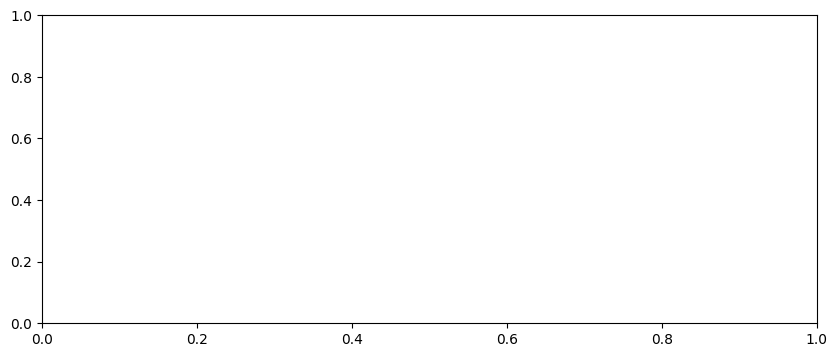

In [ ]:
# 90%那一個的圖，可以不要執行
import matplotlib.pyplot as plt

# 圖1：全域 proxy_norm 直方圖
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(proxy_norm, bins=100, color='steelblue', edgecolor='none', alpha=0.8)
for q, c, label in [(0.35,'red','Q1=0.35'), (0.60,'green','Q2=0.60'), (0.85,'orange','Q3=0.85')]:
    ax.axvline(q, color=c, linestyle='--', linewidth=1.5, label=label)
ax.set_xlabel('proxy_norm')
ax.set_ylabel('樣本數')
ax.set_title('全域 proxy_norm 分布（全部 pid 合併）')
ax.legend()
plt.tight_layout()
plt.savefig("data/processed/proxy_norm_histogram.png", dpi=150)
plt.show()

# 圖2：各 pid 時間序列
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()
for i, pid in enumerate(sorted(np.unique(groups))):
    idx = np.where(groups == pid)[0]
    p = proxy_norm[idx]
    axes[i].plot(p, linewidth=1)
    for q, c in [(0.35,'red'), (0.60,'green'), (0.85,'orange')]:
        axes[i].axhline(q, color=c, linestyle='--', linewidth=1, alpha=0.7)
    axes[i].set_title(f'P{pid:02d}  S2={int(np.sum((p>=0.60)&(p<0.85)))}')
    axes[i].set_ylim(0, 1)
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.savefig("data/processed/proxy_norm_per_pid.png", dpi=150)
plt.show()
print("✅ 兩張圖都存好了")

In [ ]:
# ===== 90 幾 % 版本_CLEAN LOGO: 5 models + per-pid normalized proxy + tuned cutpoints =====
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.model_selection import LeaveOneGroupOut, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("✅ CLEAN Evaluation: per-pid [0,1] proxy + tuned cutpoints + LOGO")
print("="*80)

# -----------------------
# Load data
# -----------------------
X      = pd.read_csv("data/processed/feature_matrix.csv")
meta   = pd.read_csv("data/processed/meta_data.csv")
groups = meta["pid"].astype(int).values

# -----------------------
# Build proxy_mono
# -----------------------
def find_col(cands, cols):
    for c in cands:
        if c in cols:
            return c
    for c in cols:
        for key in cands:
            if key.lower() in c.lower():
                return c
    return None

mq135_col  = find_col(["MQ135_Rs_R0", "mq135_rs_r0", "MQ135"], X.columns)
tgs2602_col = find_col(["TGS2602_Rs_R0", "tgs2602_rs_r0", "TGS2602"], X.columns)
if mq135_col is None or tgs2602_col is None:
    raise ValueError(f"找不到 proxy 欄位：MQ135={mq135_col}, TGS2602={tgs2602_col}")

print(f"✅ Proxy columns: MQ135={mq135_col}, TGS2602={tgs2602_col}")

proxy_raw = 0.4 * X[mq135_col].values.astype(float) + 0.6 * X[tgs2602_col].values.astype(float)

def moving_average(x, w=31):
    w = int(w)
    if w <= 1:
        return x.copy()
    if w % 2 == 0:
        w += 1
    return np.convolve(x, np.ones(w)/w, mode="same")

proxy_mono = proxy_raw.copy()
for pid in np.unique(groups):
    idx = np.where(groups == pid)[0]
    p_s = moving_average(proxy_raw[idx], 31)
    proxy_mono[idx] = np.maximum.accumulate(p_s)

# ★ Per-pid [0,1] normalization
proxy_norm = proxy_mono.copy()
for pid in np.unique(groups):
    idx  = np.where(groups == pid)[0]
    p    = proxy_mono[idx]
    pmin, pmax = p.min(), p.max()
    proxy_norm[idx] = (p - pmin) / (pmax - pmin) if pmax > pmin else np.zeros(len(idx))

# ★ Tuned cutpoints（未熟 / 可等待 / 可食用 / 過熟）
#   這裡用一組比較符合「慢熟→長時間可食用→過熟」的邊界
#   你們若之後有更好的觀察，可以改成例如 [0.20,0.45,0.80] 之類
Q1, Q2, Q3 = 0.35, 0.60, 0.85   # 未熟 / 可等待 / 可食用(寬) / 過熟(窄)

y_labels = np.zeros(len(proxy_norm), dtype=int)
y_labels[proxy_norm >= Q1] = 1
y_labels[proxy_norm >= Q2] = 2
y_labels[proxy_norm >= Q3] = 3

print(f"\n✅ Tuned cutpoints: Q1={Q1}, Q2={Q2}, Q3={Q3}")
print("📊 全域 Label 分佈：")
for s in range(4):
    cnt = int(np.sum(y_labels == s))
    print(f"  Stage {s}: {cnt:6d} ({cnt/len(y_labels)*100:4.1f}%)")

print("\n📊 Per-pid Label 分佈驗證（每個 Stage 都要有值）：")
for pid in np.unique(groups):
    idx = np.where(groups == pid)[0]
    uni, counts = np.unique(y_labels[idx], return_counts=True)
    dist = {int(k): int(v) for k, v in zip(uni, counts)}
    print(f"  P{pid:02d}: {dist}")

# -------------------------------------------------------------------
# 額外：給消費者看的文字描述（特別針對 Stage2 做內部分級）
# -------------------------------------------------------------------
def describe_stage_for_customer(proxy_norm_value: float, stage: int) -> str:
    """
    proxy_norm_value: per-pid normalize 後的 proxy（0~1）
    stage: 模型預測出的 Stage (0~3)

    回傳適合給使用者看的中文描述：
      Stage0: 未熟，不建議立即食用
      Stage1: 可等待，再放一陣子
      Stage2: 可食用區，細分為「偏生脆 / 剛好 / 偏軟」
      Stage3: 過熟，口感偏軟，建議盡快食用或考慮丟棄
    """
    if stage == 0:
        return "目前仍偏生，建議再放一段時間，暫時不建議食用。"
    if stage == 1:
        return "已經開始轉熟，但還可以再放一下，之後會更好吃。"
    if stage == 3:
        return "已偏熟甚至過熟，口感較軟，適合盡快食用或加工，挑食者可能會覺得太軟。"

    # Stage 2：可食用區，再細分 3 段
    # Stage2 區間是 [Q2, Q3)，我們在這段內再切成前1/3、中1/3、後1/3
    if stage == 2:
        if Q3 <= Q2:  # 理論上不會發生，只是防呆
            return "可食用狀態。"

        span = Q3 - Q2
        t1 = Q2 + span / 3.0
        t2 = Q2 + 2.0 * span / 3.0

        if proxy_norm_value < t1:
            # Stage2 的前 1/3：偏生脆
            return "已經可以食用，但仍偏生、口感較脆，喜歡爽脆口感的人會覺得剛好。"
        elif proxy_norm_value < t2:
            # Stage2 的中 1/3：最佳甜度
            return "目前是在最佳風味區，甜度與口感最均衡，建議現在或一兩天內食用。"
        else:
            # Stage2 的後 1/3：偏熟偏軟
            return "已接近完全成熟，口感偏軟、香氣濃，喜歡軟一點的可以現在吃，再放可能會進入過熟。"

    # 其他不預期的狀況
    return "成熟度判定中，請稍後再試一次。"

# -----------------------
# Model builders（同之前）
# -----------------------
def build_svm():
    return SVC(kernel="rbf", C=3.0, gamma="scale",
               class_weight="balanced", random_state=42)

def build_rf():
    return RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=3,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

def build_xgb():
    return XGBClassifier(
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=4,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

def build_lgbm():
    return lgb.LGBMClassifier(
        objective="multiclass",
        num_class=4,
        learning_rate=0.05,
        n_estimators=4000,
        num_leaves=63,
        min_child_samples=10,
        subsample=0.8,
        subsample_freq=1,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        force_row_wise=True,
        verbose=-1
    )

# -----------------------
# Runner functions（同之前）
# -----------------------
def run_svm(X_train, y_train, X_test):
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_train)
    X_te = scaler.transform(X_test)
    clf = build_svm()
    clf.fit(X_tr, y_train)
    return clf.predict(X_te)

def run_rf(X_train, y_train, X_test):
    clf = build_rf()
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

def run_xgb(X_train, y_train, X_test):
    clf = build_xgb()
    clf.fit(X_train, y_train)
    return np.argmax(clf.predict_proba(X_test), axis=1)

def run_lgbm(X_train, y_train, X_test):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    ti, vi = next(sss.split(X_train, y_train))
    clf = build_lgbm()
    clf.fit(
        X_train.iloc[ti], y_train[ti],
        eval_set=[(X_train.iloc[vi], y_train[vi])],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(80, verbose=False)]
    )
    return clf.predict(X_test)

def run_ensemble(X_train, y_train, X_test, w_xgb=0.5, w_lgb=0.5):
    xgb = build_xgb()
    xgb.fit(X_train, y_train)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    ti, vi = next(sss.split(X_train, y_train))
    lgbm = build_lgbm()
    lgbm.fit(
        X_train.iloc[ti], y_train[ti],
        eval_set=[(X_train.iloc[vi], y_train[vi])],
        eval_metric="multi_logloss",
        callbacks=[lgb.early_stopping(80, verbose=False)]
    )

    p = w_xgb * xgb.predict_proba(X_test) + w_lgb * lgbm.predict_proba(X_test)
    return np.argmax(p, axis=1)

MODELS = [
    ("SVM",              run_svm),
    ("RF",               run_rf),
    ("XGBoost",          run_xgb),
    ("LightGBM",         run_lgbm),
    ("XGB+LGB_Ensemble", run_ensemble),
]

# -----------------------
# LOGO folds
# -----------------------
logo   = LeaveOneGroupOut()
splits = list(logo.split(X, groups=groups))
print(f"\n✅ Total folds: {len(splits)} | PIDs: {sorted(np.unique(groups).tolist())}")

# -----------------------
# LOGO evaluation
# -----------------------
all_rows  = []
rf_yt_all = []
rf_yp_all = []

for model_name, runner in MODELS:
    print("\n" + "-"*80)
    print(f"🚀 CLEAN LOGO: {model_name}")
    print("-"*80)

    accs    = []
    per_pid = {}
    yt_fold = []
    yp_fold = []

    for train_idx, test_idx in tqdm(splits, desc=model_name, total=len(splits)):
        test_pid = int(groups[test_idx[0]])

        y_train = y_labels[train_idx]
        y_test  = y_labels[test_idx]

        X_train = X.iloc[train_idx]
        X_test  = X.iloc[test_idx]

        if model_name == "XGB+LGB_Ensemble":
            y_pred = runner(X_train, y_train, X_test, 0.5, 0.5)
        else:
            y_pred = runner(X_train, y_train, X_test)

        acc = accuracy_score(y_test, y_pred)
        accs.append(acc)
        per_pid[test_pid] = acc
        yt_fold.append(y_test)
        yp_fold.append(y_pred)

        all_rows.append({
            "model":          model_name,
            "test_pid":       test_pid,
            "test_acc_clean": acc,
            "n_test":         int(len(test_idx))
        })

    print(f"\n📊 mean={np.mean(accs)*100:.2f}%  "
          f"min={np.min(accs)*100:.2f}%  "
          f"max={np.max(accs)*100:.2f}%")
    worst = sorted(per_pid.items(), key=lambda kv: kv[1])[:3]
    print("🔻 Worst 3:", ", ".join([f"P{p}:{a*100:.2f}%" for p, a in worst]))

    if model_name == "RF":
        rf_yt_all = yt_fold
        rf_yp_all = yp_fold

# -----------------------
# Save + Summary
# -----------------------
os.makedirs("data/processed", exist_ok=True)
df      = pd.DataFrame(all_rows)
out_csv = "data/processed/clean_logo_results_5models_tuned_cutpoints.csv"
df.to_csv(out_csv, index=False, encoding="utf-8-sig")

summary = (df.groupby("model")["test_acc_clean"]
             .agg(["mean", "min", "max"])
             .reset_index())
for c in ["mean", "min", "max"]:
    summary[c] = (summary[c] * 100).round(2)

print("\n" + "="*80)
print("✅ CLEAN SUMMARY (%)  ── per-pid norm + tuned cutpoints")
print("="*80)
print(summary.to_string(index=False))
print(f"\n✅ Saved: {out_csv}")

# -----------------------
# RF Confusion Matrix + ±1 Accuracy
# -----------------------
y_true_rf = np.concatenate(rf_yt_all)
y_pred_rf  = np.concatenate(rf_yp_all)

print("\n" + "="*80)
print("🧾 RF Confusion Matrix (all folds concatenated)")
print("="*80)
print(confusion_matrix(y_true_rf, y_pred_rf))

w1 = float(np.mean(np.abs(y_true_rf - y_pred_rf) <= 1))
print(f"\n✅ RF ±1 Accuracy: {w1*100:.2f}%")

print("\n📄 RF Classification Report:")
print(classification_report(
    y_true_rf,
    y_pred_rf,
    target_names=["Stage0","Stage1","Stage2","Stage3"],
    digits=4
))

In [ ]:
# ===== v3.3：推論窗口測試（固定 Stage 定義 + per-pid proxy_norm + 時間特徵強化）=====
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

print("="*80)
print("🎯 推論窗口測試 v3.3（固定 Stage 定義 + per-pid proxy_norm + 時間特徵）")
print("   ✅ 與 CLEAN 相同：per-pid normalize + cutpoints [0.30, 0.50, 0.90]")
print("   ✅ baseline 與各窗口用同一套標籤規則（公平比較）")
print("   ✅ 追加時間特徵 time_ratio + 窗口用最後一筆成熟度")
print("="*80)

# -----------------------
# Load data
# -----------------------
X_full = pd.read_csv("data/processed/feature_matrix.csv")
meta = pd.read_csv("data/processed/meta_data.csv")
groups_full = meta["pid"].astype(int).values
pids = np.unique(groups_full)

print(f"\n📊 資料資訊:")
print(f"   樣本數: {len(X_full)}")
print(f"   鳳梨數: {len(pids)} | PIDs: {sorted(pids.tolist())}")
print(f"   meta 欄位: {list(meta.columns)}")

# -----------------------
# 加入時間特徵（每顆鳳梨 0~1 的成熟進度）
# -----------------------
if "time_idx" in meta.columns:
    # 每顆鳳梨內各自 0~1 正規化
    max_time_per_pid = meta.groupby("pid")["time_idx"].transform("max")
    X_full["time_ratio"] = meta["time_idx"] / max_time_per_pid.replace(0, 1)
else:
    # 沒有 time_idx 就給一個 fallback（幾乎不會用到）
    X_full["time_ratio"] = 0.0

# -----------------------
# Time assumption (report note)
# -----------------------
TIME_ASSUMPTION = "假設 feature_matrix 每筆代表 1 秒（若不成立，window_sec 代表『筆數』，需在報告註明）"
if "time_idx" in meta.columns:
    TIME_ASSUMPTION = "基於 meta.time_idx（假設每筆間隔約 1 秒；若間隔非1，window_sec代表time_idx單位）"
elif "timestamp" in meta.columns or "timestamp_s" in meta.columns:
    ts_col = "timestamp" if "timestamp" in meta.columns else "timestamp_s"
    diffs_all = []
    for pid in pids[:3]:
        idx = np.where(groups_full == pid)[0]
        ts = pd.to_numeric(meta.loc[idx, ts_col], errors="coerce").values
        ts = ts[np.isfinite(ts)]
        if len(ts) > 5:
            diffs = np.diff(ts)
            diffs = diffs[np.isfinite(diffs)]
            if len(diffs) > 0:
                diffs_all.append(np.median(diffs))
    if len(diffs_all) > 0:
        TIME_ASSUMPTION = f"基於 meta.{ts_col}，抽查中位數時間間隔約 {np.median(diffs_all):.3f} 秒（window_sec以此為參考）"

print(f"\n📝 時間假設: {TIME_ASSUMPTION}")

# -----------------------
# Proxy columns robust find
# -----------------------
def find_col(cands, cols):
    for c in cands:
        if c in cols:
            return c
    for c in cols:
        for key in cands:
            if key.lower() in c.lower():
                return c
    return None

mq135_col = find_col(["MQ135_Rs_R0", "mq135_rs_r0", "MQ135"], X_full.columns)
tgs2602_col = find_col(["TGS2602_Rs_R0", "tgs2602_rs_r0", "TGS2602"], X_full.columns)
if mq135_col is None or tgs2602_col is None:
    raise ValueError(f"找不到 proxy 欄位：MQ135={mq135_col}, TGS2602={tgs2602_col}")

print(f"✅ Proxy columns: MQ135={mq135_col}, TGS2602={tgs2602_col}")

# -----------------------
# Build full-resolution proxy_mono
# -----------------------
proxy_raw = 0.4 * X_full[mq135_col].values.astype(float) + 0.6 * X_full[tgs2602_col].values.astype(float)

def moving_average(x, w=31):
    w = int(w)
    if w <= 1:
        return x.copy()
    if w % 2 == 0:
        w += 1
    k = np.ones(w, dtype=float) / w
    return np.convolve(x, k, mode="same")

SMOOTH_W = 31
proxy_mono = proxy_raw.copy()
for pid in pids:
    idx = np.where(groups_full == pid)[0]
    p_s = moving_average(proxy_raw[idx], SMOOTH_W)
    proxy_mono[idx] = np.maximum.accumulate(p_s)

# ★ per-pid normalize 到 [0,1]（與 CLEAN 相同）
proxy_norm_full = proxy_mono.copy()
for pid in pids:
    idx = np.where(groups_full == pid)[0]
    p = proxy_mono[idx]
    pmin, pmax = p.min(), p.max()
    proxy_norm_full[idx] = (p - pmin) / (pmax - pmin) if pmax > pmin else np.zeros(len(idx))

# -----------------------
# Window compression (non-overlapping)
# 這裡：
#   - 特徵：仍用平均（穩定一點）
#   - proxy_norm：用窗口「最後一筆」代表這個窗口的成熟度
# -----------------------
MIN_COVER = 0.80

def compress_to_windows(X, proxy_full_norm, groups, window_sec):
    X_rows, proxy_rows, pid_rows = [], [], []
    for pid in np.unique(groups):
        idx = np.where(groups == pid)[0]
        X_pid = X.iloc[idx]
        p_pid = proxy_full_norm[idx]
        n = len(idx)
        step = int(window_sec)

        for start in range(0, n, step):
            end = min(start + step, n)
            if (end - start) < int(step * MIN_COVER):
                continue
            # 特徵用平均
            X_rows.append(X_pid.iloc[start:end].mean(axis=0))
            # 成熟度用「最後一筆」proxy_norm（更符合時間上「量完這段之後」的狀態）
            proxy_rows.append(float(p_pid[end - 1]))
            pid_rows.append(int(pid))

    Xc = pd.DataFrame(X_rows, columns=X.columns)
    pc = np.array(proxy_rows, dtype=float)
    gc = np.array(pid_rows, dtype=int)
    return Xc, pc, gc

# -----------------------
# XGB model（強化版，仍然合理）
# -----------------------
def build_xgb():
    return XGBClassifier(
        n_estimators=900,        # 多一點樹，學比較細
        max_depth=8,            # 深一點，處理 Stage2/3 邊界
        learning_rate=0.03,     # 步伐小一點，穩定
        subsample=0.9,
        colsample_bytree=0.9,
        gamma=0.1,
        min_child_weight=2,
        reg_lambda=1.2,
        objective="multi:softprob",
        num_class=4,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

# -----------------------
# Labeler：使用固定 cutpoints [0.30,0.50,0.90]（與 CLEAN 相同）
# -----------------------
Q1, Q2, Q3 = 0.30, 0.50, 0.90

def label_with_fixed_cutpoints(proxy_norm_array):
    """
    proxy_norm_array: 已經 per-pid normalize 到 [0,1] 的 proxy（可以是逐筆或窗口代表值）
    回傳: y (0~3)
    """
    y = np.zeros(len(proxy_norm_array), dtype=int)
    y[proxy_norm_array >= Q1] = 1
    y[proxy_norm_array >= Q2] = 2
    y[proxy_norm_array >= Q3] = 3
    return y

print(f"\n✅ 固定 cutpoints: Q1={Q1}, Q2={Q2}, Q3={Q3}")
print("   （與 CLEAN cell 的 Stage 定義一致）")

# -----------------------
# Baseline (window = 1, fixed labeling, LOGO)
# -----------------------
print("\n" + "="*80)
print("📊 計算 Baseline（完整資料 window=1；固定 cutpoints + 時間特徵）")
print("="*80)

logo_full = LeaveOneGroupOut()
baseline_accs = []
baseline_per_pid = {}

# 事先對 full-resolution 做標籤（不依賴 train/test）
y_all_full = label_with_fixed_cutpoints(proxy_norm_full)

for train_idx, test_idx in tqdm(
    logo_full.split(X_full, groups=groups_full),
    total=len(pids),
    desc="Baseline",
    leave=False
):
    test_pid = int(groups_full[test_idx[0]])

    X_train = X_full.iloc[train_idx]
    X_test  = X_full.iloc[test_idx]
    y_train = y_all_full[train_idx]
    y_test  = y_all_full[test_idx]

    if len(np.unique(y_train)) < 2:
        continue

    clf = build_xgb()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    baseline_accs.append(acc)
    baseline_per_pid[test_pid] = acc

BASELINE_ACC = float(np.mean(baseline_accs) * 100) if len(baseline_accs) else float("nan")
BASELINE_STD = float(np.std(baseline_accs) * 100) if len(baseline_accs) else float("nan")

print(f"✅ Baseline: {BASELINE_ACC:.2f}% ± {BASELINE_STD:.2f}% | feasible {len(baseline_per_pid)}/{len(pids)}")

# -----------------------
# Window tests
# -----------------------
WINDOW_SIZES = [5, 10, 15, 30, 60, 120, 300, 600]
results = []

print("\n" + "="*80)
print("開始窗口測試（固定 cutpoints + per-pid proxy_norm + 時間特徵）")
print("="*80)

for window_sec in WINDOW_SIZES:
    print(f"\n⏱ 窗口: {window_sec} 秒")

    # 使用 proxy_norm_full 來壓縮，proxy_comp_norm 為「最後一筆」proxy_norm
    X_comp, proxy_comp_norm, groups_comp = compress_to_windows(
        X_full, proxy_norm_full, groups_full, window_sec
    )
    if len(X_comp) == 0:
        print("   ❌ 壓縮後無樣本，跳過")
        continue

    print(f"   ✅ 壓縮後: {len(X_comp)} 樣本 | 平均窗口/鳳梨: {len(X_comp)/len(pids):.1f}")

    logo = LeaveOneGroupOut()
    accs = []
    per_pid_acc = {}
    feasible_pids = []

    # 先對壓縮後 proxy_norm 做標籤（同一套 cutpoints）
    y_comp = label_with_fixed_cutpoints(proxy_comp_norm)

    for train_idx, test_idx in tqdm(
        logo.split(X_comp, groups=groups_comp),
        total=len(pids),
        desc=f"{window_sec}s",
        leave=False
    ):
        test_pid = int(groups_comp[test_idx[0]])

        X_train = X_comp.iloc[train_idx]
        X_test  = X_comp.iloc[test_idx]
        y_train = y_comp[train_idx]
        y_test  = y_comp[test_idx]

        if len(np.unique(y_train)) < 2 or len(y_test) == 0:
            continue

        clf = build_xgb()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        accs.append(acc)
        per_pid_acc[test_pid] = acc
        feasible_pids.append(test_pid)

    feasible_rate = len(set(feasible_pids)) / len(pids) * 100.0

    if len(accs) == 0:
        print("   ❌ 無有效結果")
        results.append({
            "window_sec": window_sec,
            "window_min": window_sec / 60.0,
            "n_samples": int(len(X_comp)),
            "mean_acc": np.nan,
            "std_acc": np.nan,
            "min_acc": np.nan,
            "max_acc": np.nan,
            "feasible_rate": feasible_rate,
            "vs_baseline": np.nan
        })
        continue

    mean_acc = float(np.mean(accs) * 100)
    std_acc  = float(np.std(accs) * 100)
    min_acc  = float(np.min(accs) * 100)
    max_acc  = float(np.max(accs) * 100)
    vs_base  = mean_acc - BASELINE_ACC

    print(f"   📊 {mean_acc:.2f}% ± {std_acc:.2f}% | range {min_acc:.2f}~{max_acc:.2f} | feasible {feasible_rate:.0f}% | vs base {vs_base:+.2f}%")

    if len(per_pid_acc) >= 3:
        worst_3 = sorted(per_pid_acc.items(), key=lambda kv: kv[1])[:3]
        print("   🔻 Worst 3:", ", ".join([f"P{pid}:{acc*100:.1f}%" for pid, acc in worst_3]))

    results.append({
        "window_sec": window_sec,
        "window_min": window_sec / 60.0,
        "n_samples": int(len(X_comp)),
        "n_feasible": int(len(set(feasible_pids))),
        "feasible_rate": feasible_rate,
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "min_acc": min_acc,
        "max_acc": max_acc,
        "vs_baseline": vs_base
    })

# -----------------------
# Summary + save + recommendation
# -----------------------
df_results = pd.DataFrame(results).sort_values("window_sec").reset_index(drop=True)

print("\n" + "="*80)
print("📊 最終結果（固定 cutpoints + per-pid proxy_norm + 時間特徵）")
print("="*80)
print(f"Baseline: {BASELINE_ACC:.2f}% ± {BASELINE_STD:.2f}%")
print(f"時間假設: {TIME_ASSUMPTION}\n")
print(df_results.to_string(index=False))

os.makedirs("data/processed", exist_ok=True)
out_csv = "data/processed/inference_window_v33_timefeat_lastproxy.csv"
df_results.to_csv(out_csv, index=False, encoding="utf-8-sig")
print(f"\n✅ Saved: {out_csv}")

print("\n" + "="*80)
print("💡 Raspberry Pi 部署建議（同時要求可行率）")
print("="*80)

found = False
for threshold in [93, 90, 85, 80]:
    acceptable = df_results.dropna(subset=["mean_acc"])
    acceptable = acceptable[(acceptable["mean_acc"] >= threshold) & (acceptable["feasible_rate"] >= 90)].sort_values("window_sec")
    if len(acceptable) > 0:
        best = acceptable.iloc[0]
        print(f"\n✅ 若要 ≥{threshold}% 準確率 (Baseline: {BASELINE_ACC:.2f}%)")
        print(f"   最短窗口: {int(best['window_sec'])} 秒 ({best['window_min']:.2f} 分)")
        print(f"   預期準確率: {best['mean_acc']:.2f}% ± {best['std_acc']:.2f}%")
        print(f"   可行率: {best['feasible_rate']:.1f}% ({int(best['n_feasible'])}/{len(pids)})")
        print(f"   vs Baseline: {best['vs_baseline']:+.2f}%")
        found = True
        break

if not found:
    print("\n⚠️ 無法同時滿足「≥80% 準確率 + ≥90% 可行率」")
    if len(df_results.dropna(subset=["mean_acc"])) > 0:
        best = df_results.dropna(subset=["mean_acc"]).iloc[df_results["mean_acc"].idxmax()]
        print(f"   最佳窗口: {int(best['window_sec'])} 秒 ({best['mean_acc']:.2f}%)")

🎯 推論窗口測試 v3.3（固定 Stage 定義 + per-pid proxy_norm + 時間特徵）
   ✅ 與 CLEAN 相同：per-pid normalize + cutpoints [0.30, 0.50, 0.90]
   ✅ baseline 與各窗口用同一套標籤規則（公平比較）
   ✅ 追加時間特徵 time_ratio + 窗口用最後一筆成熟度

📊 資料資訊:
   樣本數: 107998
   鳳梨數: 11 | PIDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
   meta 欄位: ['pid', 'date', 'time_idx']

📝 時間假設: 基於 meta.time_idx（假設每筆間隔約 1 秒；若間隔非1，window_sec代表time_idx單位）
✅ Proxy columns: MQ135=MQ135_Rs_R0, TGS2602=TGS2602_Rs_R0

✅ 固定 cutpoints: Q1=0.3, Q2=0.5, Q3=0.9
   （與 CLEAN cell 的 Stage 定義一致）

📊 計算 Baseline（完整資料 window=1；固定 cutpoints + 時間特徵）


✅ Baseline: 79.88% ± 19.24% | feasible 11/11

開始窗口測試（固定 cutpoints + per-pid proxy_norm + 時間特徵）

⏱ 窗口: 5 秒
   ✅ 壓縮後: 21599 樣本 | 平均窗口/鳳梨: 1963.5


   📊 80.46% ± 19.48% | range 54.91~99.95 | feasible 100% | vs base +0.57%
   🔻 Worst 3: P4:54.9%, P7:55.0%, P3:58.5%

⏱ 窗口: 10 秒
   ✅ 壓縮後: 10800 樣本 | 平均窗口/鳳梨: 981.8


   📊 80.55% ± 19.32% | range 53.94~99.93 | feasible 100% | vs base +0.67%
   🔻 Worst 3: P7:53.9%, P4:55.0%, P3:58.3%

⏱ 窗口: 15 秒
   ✅ 壓縮後: 7200 樣本 | 平均窗口/鳳梨: 654.5


   📊 78.41% ± 20.09% | range 52.50~100.00 | feasible 100% | vs base -1.47%
   🔻 Worst 3: P4:52.5%, P7:54.4%, P3:58.5%

⏱ 窗口: 30 秒
   ✅ 壓縮後: 3600 樣本 | 平均窗口/鳳梨: 327.3


   📊 78.15% ± 20.34% | range 53.33~100.00 | feasible 100% | vs base -1.73%
   🔻 Worst 3: P4:53.3%, P7:55.2%, P3:58.6%

⏱ 窗口: 60 秒
   ✅ 壓縮後: 1800 樣本 | 平均窗口/鳳梨: 163.6


   📊 77.72% ± 20.73% | range 53.33~100.00 | feasible 100% | vs base -2.17%
   🔻 Worst 3: P4:53.3%, P7:55.8%, P11:55.8%

⏱ 窗口: 120 秒
   ✅ 壓縮後: 898 樣本 | 平均窗口/鳳梨: 81.6


   📊 81.79% ± 18.33% | range 56.10~100.00 | feasible 100% | vs base +1.91%
   🔻 Worst 3: P7:56.1%, P8:59.8%, P4:60.0%

⏱ 窗口: 300 秒
   ✅ 壓縮後: 360 樣本 | 平均窗口/鳳梨: 32.7


   📊 81.62% ± 17.93% | range 58.33~100.00 | feasible 100% | vs base +1.74%
   🔻 Worst 3: P4:58.3%, P8:60.6%, P3:61.1%

⏱ 窗口: 600 秒
   ✅ 壓縮後: 178 樣本 | 平均窗口/鳳梨: 16.2


   📊 81.76% ± 18.06% | range 56.25~100.00 | feasible 100% | vs base +1.87%
   🔻 Worst 3: P8:56.2%, P3:61.1%, P4:61.1%

📊 最終結果（固定 cutpoints + per-pid proxy_norm + 時間特徵）
Baseline: 79.88% ± 19.24%
時間假設: 基於 meta.time_idx（假設每筆間隔約 1 秒；若間隔非1，window_sec代表time_idx單位）

 window_sec  window_min  n_samples  n_feasible  feasible_rate  mean_acc   std_acc   min_acc    max_acc  vs_baseline
          5    0.083333      21599          11          100.0 80.458500 19.477897 54.907407  99.953704     0.574752
         10    0.166667      10800          11          100.0 80.553043 19.320921 53.939394  99.930556     0.669295
         15    0.250000       7200          11          100.0 78.414601 20.087753 52.500000 100.000000    -1.469148
         30    0.500000       3600          11          100.0 78.151974 20.335928 53.333333 100.000000    -1.731774
         60    1.000000       1800          11          100.0 77.715794 20.732356 53.333333 100.000000    -2.167954
        120    2.000000        898          